In [1]:
# Basic libraries
import torch
import torch.nn as n
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List
import torch.optim as optim
from tqdm import tqdm
from omegaconf import OmegaConf

In [2]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *
from osgen.pipeline import *

In [3]:
# Load config
cfg = OmegaConf.load("/root/BiOSGen/configs/train_config.yml")
print(cfg.verbose)

True


In [4]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


In [5]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[idx_dst]))),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


In [6]:
# Initialize your pipeline
pipeline = OSGenPipeline()

# # Load the checkpoint file (a state_dict)
# checkpoints = torch.load("/root/BiOSGen/checkpoints/main/pipeline_full_best_100_epoch_512.pth")


In [7]:
# checkpoint_keys = set(checkpoints['model_state_dict'].keys())
# pipeline_keys = set(pipeline.state_dict().keys())

# print("Keys only in checkpoint:", checkpoint_keys - pipeline_keys)
# print("Keys only in pipeline:", pipeline_keys - checkpoint_keys)
# print("Common keys:", checkpoint_keys & pipeline_keys)

# # Check for shape mismatches in common keys
# print("\nShape mismatches:")
# for key in checkpoint_keys & pipeline_keys:
#     if checkpoints['model_state_dict'][key].shape != pipeline.state_dict()[key].shape:
#         print(f"{key}: checkpoint shape = {checkpoints['model_state_dict'][key].shape}, pipeline shape = {pipeline.state_dict()[key].shape}")

In [8]:
# Hyperparameters
verbose = cfg.verbose
num_epochs = 10
batch_size = cfg.batch_size
lr = cfg.lr
optimizer = optim.AdamW([p for p in pipeline.parameters() if p.requires_grad], 
                        lr=cfg.optimizer.params.lr, weight_decay=cfg.optimizer.params.weight_decay, eps=cfg.optimizer.params.eps)

channels = cfg.channels
height = cfg.height
width = cfg.width
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lambda_content = cfg.lambda_content
lambda_style = cfg.lambda_style

# Training loop
# Put on training mode
pipeline.train()
requires_grad = True

# Early stopping parameters
early_stopping_patience = cfg.early_stopping_patience
epochs_without_improvement = 0
best_loss = float("inf")

# Convergence check parameters
convergence_patience = 5  # Number of epochs to check for convergence
convergence_threshold = 0.001  # Minimum relative change in loss to continue training
loss_history = []  # Keep track of recent losses

# Save losses
losses = []
content_losses = []
style_losses = []

# Switch to main training with bfloat16
for epoch in tqdm(range(num_epochs)):
    # print(f"Epoch {epoch+1}/{num_epochs}")
    avg_loss = []
    content_loss = []
    style_loss = []

    for i, (src, dst) in enumerate(zip(patches_src, patches_dst)):
        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        decoded = pipeline(src_tensor, dst_tensor, timesteps)

        # Handle gradients issues
        requires_grad = decoded.requires_grad
        # print(requires_grad)
        if not requires_grad:
            break

        # Compute loss
        content_l, style_l, total_loss = pipeline.compute_loss(src_tensor, dst_tensor, decoded, lambda_content, lambda_style)

        # Break if total_loss is NaN
        if torch.isnan(total_loss):
            print(f"NaN loss at epoch {epoch+1}, batch {i+1}")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")

        avg_loss.append(total_loss.item())
        content_loss.append(content_l.item())
        style_loss.append(style_l.item())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
    current_loss = np.mean(avg_loss)
    losses.append(current_loss)
    content_losses.append(np.mean(content_loss))
    style_losses.append(np.mean(style_loss))

    # Early stopping (original implementation)
    if current_loss < best_loss:
        best_loss = current_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if verbose: 
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")
            
            # Save the checkpoints
            torch.save(pipeline.state_dict(), f"/root/BiOSGen/checkpoints/pipeline_epoch_{epoch+1}.pth")
            print(f"Model saved at /root/BiOSGen/checkpoints/pipeline_epoch_{epoch+1}.pth")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Batch 1/95, Content Loss: 74.1390, Style Loss: 24.3701, Total Loss: 98.5091
Epoch 1/10, Batch 2/95, Content Loss: 49.8104, Style Loss: 23.7808, Total Loss: 73.5912
Epoch 1/10, Batch 3/95, Content Loss: 39.0819, Style Loss: 13.2028, Total Loss: 52.2848
Epoch 1/10, Batch 4/95, Content Loss: 39.0449, Style Loss: 26.7640, Total Loss: 65.8089
Epoch 1/10, Batch 5/95, Content Loss: 43.5288, Style Loss: 48.1009, Total Loss: 91.6297
Epoch 1/10, Batch 6/95, Content Loss: 105.6132, Style Loss: 198.2707, Total Loss: 303.8839
Epoch 1/10, Batch 7/95, Content Loss: 82.1105, Style Loss: 44.0333, Total Loss: 126.1439
Epoch 1/10, Batch 8/95, Content Loss: 89.4172, Style Loss: 49.4282, Total Loss: 138.8454
Epoch 1/10, Batch 9/95, Content Loss: 100.4985, Style Loss: 31.2968, Total Loss: 131.7953
Epoch 1/10, Batch 10/95, Content Loss: 87.1970, Style Loss: 17.1434, Total Loss: 104.3404
Epoch 1/10, Batch 11/95, Content Loss: 67.7644, Style Loss: 17.0558, Total Loss: 84.8202
Epoch 1/10, Batch 12/9

 10%|█         | 1/10 [00:15<02:22, 15.86s/it]

Model saved at /root/BiOSGen/checkpoints/pipeline_epoch_1.pth
Epoch 2/10, Batch 1/95, Content Loss: 27.3187, Style Loss: 11.9639, Total Loss: 39.2826
Epoch 2/10, Batch 2/95, Content Loss: 28.5082, Style Loss: 7.4671, Total Loss: 35.9754
Epoch 2/10, Batch 3/95, Content Loss: 24.1734, Style Loss: 8.3993, Total Loss: 32.5727
Epoch 2/10, Batch 4/95, Content Loss: 21.2861, Style Loss: 4.1791, Total Loss: 25.4652
Epoch 2/10, Batch 5/95, Content Loss: 28.3065, Style Loss: 7.3904, Total Loss: 35.6969
Epoch 2/10, Batch 6/95, Content Loss: 38.4015, Style Loss: 12.9983, Total Loss: 51.3997
Epoch 2/10, Batch 7/95, Content Loss: 59.3432, Style Loss: 15.5038, Total Loss: 74.8470
Epoch 2/10, Batch 8/95, Content Loss: 46.2761, Style Loss: 15.2165, Total Loss: 61.4926
Epoch 2/10, Batch 9/95, Content Loss: 49.9047, Style Loss: 5.1351, Total Loss: 55.0397
Epoch 2/10, Batch 10/95, Content Loss: 57.9833, Style Loss: 14.1960, Total Loss: 72.1793
Epoch 2/10, Batch 11/95, Content Loss: 44.5870, Style Loss: 4.

 20%|██        | 2/10 [00:28<01:52, 14.08s/it]

Epoch 3/10, Batch 1/95, Content Loss: 21.4432, Style Loss: 7.9982, Total Loss: 29.4414
Epoch 3/10, Batch 2/95, Content Loss: 26.3505, Style Loss: 6.1993, Total Loss: 32.5499
Epoch 3/10, Batch 3/95, Content Loss: 20.6141, Style Loss: 7.6709, Total Loss: 28.2849
Epoch 3/10, Batch 4/95, Content Loss: 20.0853, Style Loss: 6.3699, Total Loss: 26.4553
Epoch 3/10, Batch 5/95, Content Loss: 26.6494, Style Loss: 8.9056, Total Loss: 35.5551
Epoch 3/10, Batch 6/95, Content Loss: 36.2097, Style Loss: 14.1982, Total Loss: 50.4079
Epoch 3/10, Batch 7/95, Content Loss: 58.9802, Style Loss: 17.0870, Total Loss: 76.0672
Epoch 3/10, Batch 8/95, Content Loss: 45.3820, Style Loss: 14.5007, Total Loss: 59.8827
Epoch 3/10, Batch 9/95, Content Loss: 48.8701, Style Loss: 6.7872, Total Loss: 55.6572
Epoch 3/10, Batch 10/95, Content Loss: 57.2333, Style Loss: 11.1782, Total Loss: 68.4115
Epoch 3/10, Batch 11/95, Content Loss: 44.0851, Style Loss: 4.0433, Total Loss: 48.1283
Epoch 3/10, Batch 12/95, Content Loss

 30%|███       | 3/10 [00:41<01:34, 13.47s/it]

Epoch 4/10, Batch 1/95, Content Loss: 19.5074, Style Loss: 7.9322, Total Loss: 27.4396
Epoch 4/10, Batch 2/95, Content Loss: 21.7635, Style Loss: 5.9280, Total Loss: 27.6914
Epoch 4/10, Batch 3/95, Content Loss: 18.3052, Style Loss: 5.9177, Total Loss: 24.2229
Epoch 4/10, Batch 4/95, Content Loss: 15.8132, Style Loss: 8.7379, Total Loss: 24.5510
Epoch 4/10, Batch 5/95, Content Loss: 24.7083, Style Loss: 9.3243, Total Loss: 34.0326
Epoch 4/10, Batch 6/95, Content Loss: 37.3733, Style Loss: 11.3968, Total Loss: 48.7701
Epoch 4/10, Batch 7/95, Content Loss: 59.4878, Style Loss: 18.3583, Total Loss: 77.8460
Epoch 4/10, Batch 8/95, Content Loss: 46.4845, Style Loss: 15.3145, Total Loss: 61.7990
Epoch 4/10, Batch 9/95, Content Loss: 46.4490, Style Loss: 5.3248, Total Loss: 51.7739
Epoch 4/10, Batch 10/95, Content Loss: 52.4578, Style Loss: 12.0202, Total Loss: 64.4780
Epoch 4/10, Batch 11/95, Content Loss: 39.5597, Style Loss: 5.3236, Total Loss: 44.8834
Epoch 4/10, Batch 12/95, Content Loss

 40%|████      | 4/10 [00:54<01:19, 13.19s/it]

Epoch 5/10, Batch 1/95, Content Loss: 16.2766, Style Loss: 5.9624, Total Loss: 22.2391
Epoch 5/10, Batch 2/95, Content Loss: 20.9071, Style Loss: 7.0113, Total Loss: 27.9184
Epoch 5/10, Batch 3/95, Content Loss: 16.0929, Style Loss: 5.7509, Total Loss: 21.8438
Epoch 5/10, Batch 4/95, Content Loss: 10.5793, Style Loss: 8.3860, Total Loss: 18.9653
Epoch 5/10, Batch 5/95, Content Loss: 19.6695, Style Loss: 11.6562, Total Loss: 31.3257
Epoch 5/10, Batch 6/95, Content Loss: 34.6099, Style Loss: 11.5175, Total Loss: 46.1274
Epoch 5/10, Batch 7/95, Content Loss: 54.6116, Style Loss: 14.6905, Total Loss: 69.3021
Epoch 5/10, Batch 8/95, Content Loss: 42.2000, Style Loss: 13.4994, Total Loss: 55.6994
Epoch 5/10, Batch 9/95, Content Loss: 46.5729, Style Loss: 7.9371, Total Loss: 54.5100
Epoch 5/10, Batch 10/95, Content Loss: 49.7299, Style Loss: 16.7397, Total Loss: 66.4696
Epoch 5/10, Batch 11/95, Content Loss: 38.8493, Style Loss: 4.8454, Total Loss: 43.6946
Epoch 5/10, Batch 12/95, Content Los

 50%|█████     | 5/10 [01:07<01:05, 13.05s/it]

Epoch 6/10, Batch 1/95, Content Loss: 16.4307, Style Loss: 4.6904, Total Loss: 21.1211
Epoch 6/10, Batch 2/95, Content Loss: 20.8181, Style Loss: 5.3155, Total Loss: 26.1337
Epoch 6/10, Batch 3/95, Content Loss: 16.5243, Style Loss: 5.0183, Total Loss: 21.5426
Epoch 6/10, Batch 4/95, Content Loss: 11.3478, Style Loss: 6.4790, Total Loss: 17.8269
Epoch 6/10, Batch 5/95, Content Loss: 20.6147, Style Loss: 9.9493, Total Loss: 30.5639
Epoch 6/10, Batch 6/95, Content Loss: 33.9663, Style Loss: 9.7403, Total Loss: 43.7066
Epoch 6/10, Batch 7/95, Content Loss: 52.4793, Style Loss: 9.9273, Total Loss: 62.4066
Epoch 6/10, Batch 8/95, Content Loss: 42.0350, Style Loss: 12.2841, Total Loss: 54.3191
Epoch 6/10, Batch 9/95, Content Loss: 43.5706, Style Loss: 4.9792, Total Loss: 48.5497
Epoch 6/10, Batch 10/95, Content Loss: 48.9486, Style Loss: 13.0022, Total Loss: 61.9508
Epoch 6/10, Batch 11/95, Content Loss: 36.5906, Style Loss: 6.9406, Total Loss: 43.5312
Epoch 6/10, Batch 12/95, Content Loss: 

 60%|██████    | 6/10 [01:19<00:51, 13.00s/it]

Epoch 7/10, Batch 1/95, Content Loss: 15.5615, Style Loss: 5.5395, Total Loss: 21.1010
Epoch 7/10, Batch 2/95, Content Loss: 18.9498, Style Loss: 5.1824, Total Loss: 24.1322
Epoch 7/10, Batch 3/95, Content Loss: 14.8477, Style Loss: 5.9694, Total Loss: 20.8171
Epoch 7/10, Batch 4/95, Content Loss: 9.1980, Style Loss: 6.0579, Total Loss: 15.2558
Epoch 7/10, Batch 5/95, Content Loss: 19.9805, Style Loss: 12.9235, Total Loss: 32.9040
Epoch 7/10, Batch 6/95, Content Loss: 40.0200, Style Loss: 6.0043, Total Loss: 46.0243
Epoch 7/10, Batch 7/95, Content Loss: 54.4360, Style Loss: 5.5123, Total Loss: 59.9483
Epoch 7/10, Batch 8/95, Content Loss: 41.2451, Style Loss: 8.3607, Total Loss: 49.6058
Epoch 7/10, Batch 9/95, Content Loss: 42.6958, Style Loss: 6.3328, Total Loss: 49.0286
Epoch 7/10, Batch 10/95, Content Loss: 48.4556, Style Loss: 14.0193, Total Loss: 62.4749
Epoch 7/10, Batch 11/95, Content Loss: 36.1216, Style Loss: 9.6113, Total Loss: 45.7329
Epoch 7/10, Batch 12/95, Content Loss: 2

 60%|██████    | 6/10 [01:27<00:58, 14.63s/it]


KeyboardInterrupt: 

In [ ]:
# # After your training loop
# # Save model components
# torch.save(pipeline.state_dict(), '/root/BiOSGen/checkpoints/main/pipeline_best_100_epoch_512.pth')

# # Save the entire model state including optimizer
# checkpoint = {
#     'epoch': epoch,
#     'model_state_dict': pipeline.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'best_loss': best_loss,
#     'losses': losses,
#     'content_losses': content_losses,
#     'style_losses': style_losses
# }

# torch.save(checkpoint, '/root/BiOSGen/checkpoints/main/pipeline_full_100_epoch_512.pth')

Text(0.5, 1.0, 'Generated Image')

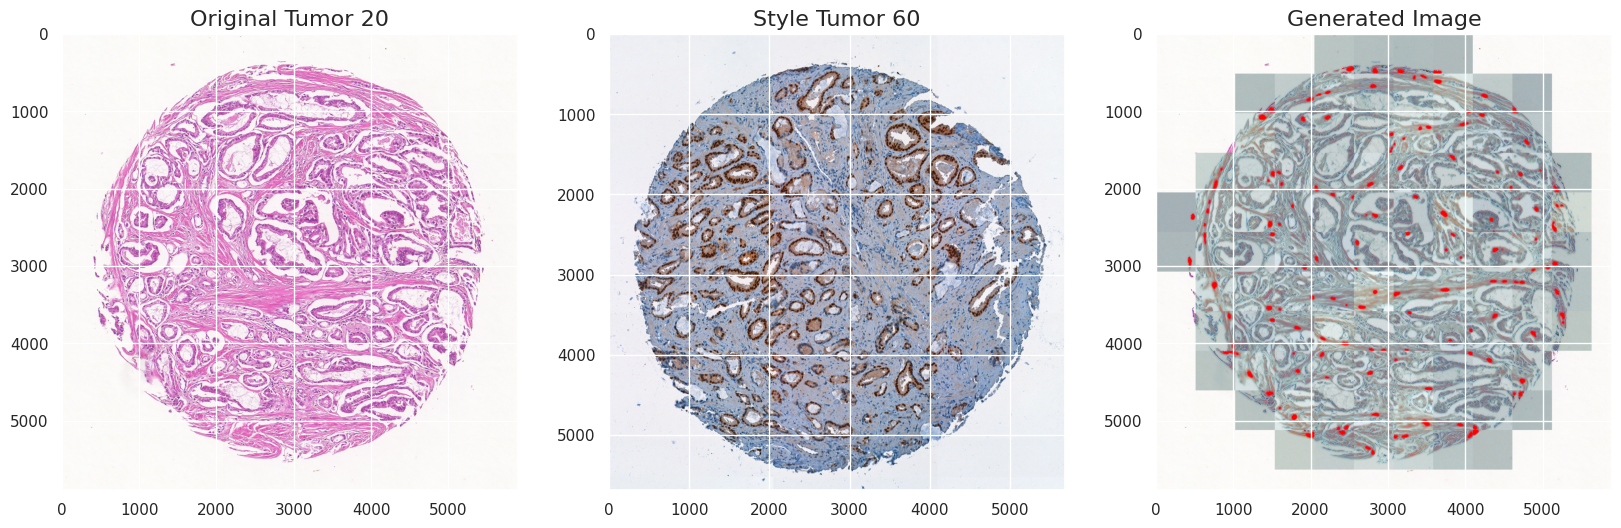

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask=PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)

In [ ]:


idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

# ==================================================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[i]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image_full(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)

idx_src:  20
idx_dst:  60


Text(0.5, 1.0, 'Generated Image')

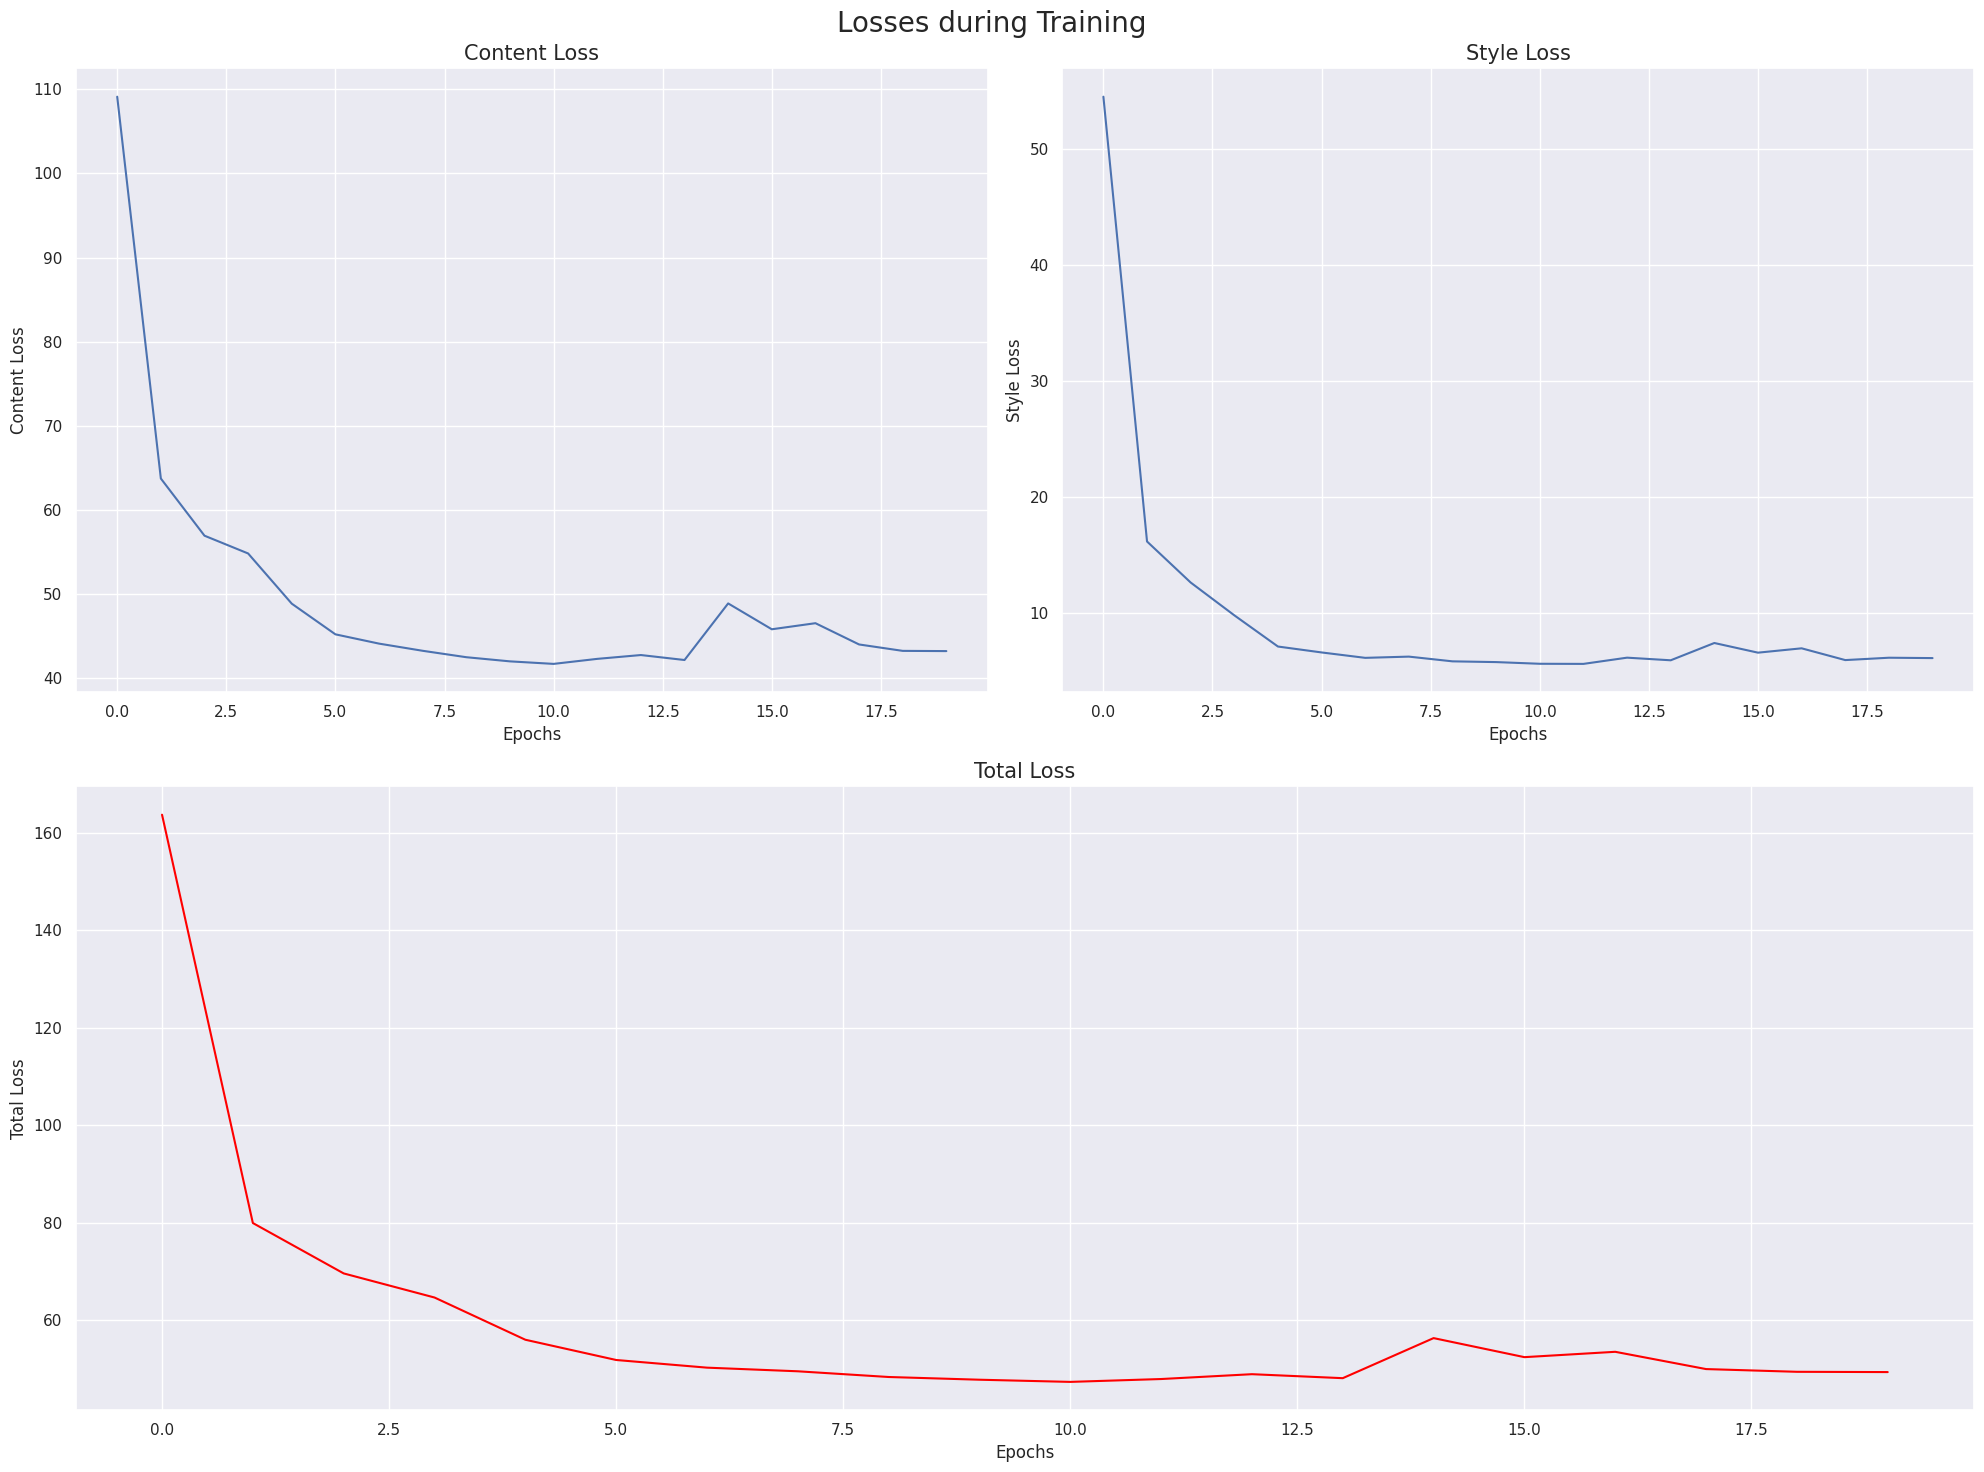

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Upper left: Content Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(content_losses, label='Content Loss')
ax1.set_title('Content Loss', fontsize=15)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Content Loss')

# Upper right: Style Loss
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(style_losses, label='Style Loss')
ax2.set_title('Style Loss', fontsize=15)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Style Loss')

# Bottom (spans both columns): Total Loss
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(losses, label='Total Loss', color='red')
ax3.set_title('Total Loss', fontsize=15)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Total Loss')

# Add title to fig
fig.suptitle('Losses during Training', fontsize=20)
plt.tight_layout()
plt.show()


In [ ]:
pipeline.eval()
# for m in pipeline.modules():
#     if isinstance(m, nn.BatchNorm2d):
#         m.train()


OSGenPipeline(
  (encoder): VanillaEncoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (fc_mu): Linear(in_features=32, out_features=64, bias=True)
    (fc_var): Linear(in_features=32, out_features=64, bias=True)
    (noise_predictor): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (decoder_input): Linear(in_features=64, out_features=8192, bias=True)
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=

In [ ]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


Text(0.5, 1.0, 'Generated Image')

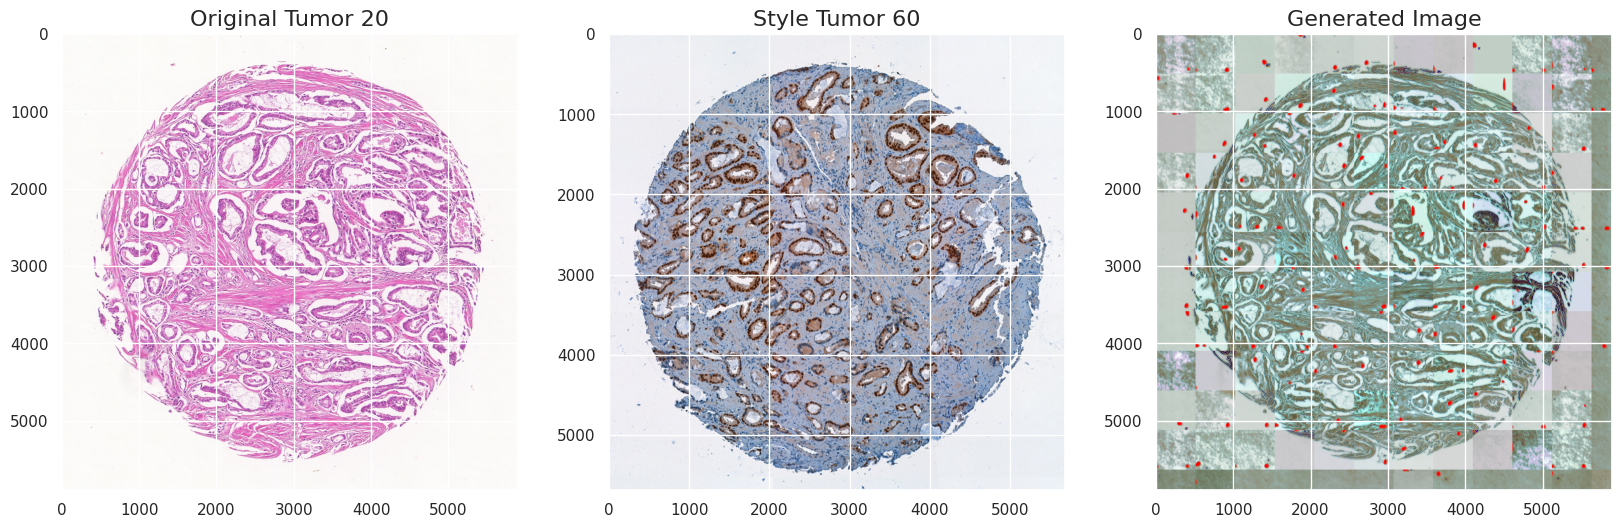

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[i]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image_full(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)